<a href="https://colab.research.google.com/github/zain711/dcipher/blob/main/vaccines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bertopic
!pip install bertopic[visualization]
!pip install bert-extractive-summarizer
!pip install plotly
!pip install torch
!pip install tensorflow
!pip install flair

In [41]:
import json
import pandas as pd
import torch
from bertopic import BERTopic
import os
import nltk 
import numpy as np
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer , WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Preprocessing Text**

In [14]:
#previous vaccine forums
datas = pd.read_json('/content/drive/MyDrive/vaccine-forums-tokenized.json')
docss = list(datas.loc[:, "cleaned_post_text"].values)
timess = list(datas.loc[:, "post_published_at"].values)

In [15]:
data = pd.read_json('/content/drive/MyDrive/vaccine-merged-segmented.json')
docs = list(data.loc[:, "text"].values)
times = list(data.loc[:, "date"].values)

In [16]:
new_data = data.groupby(['date']).sum()
new_data.head(3)

,text,tokens
date,,
2020-09-28 09:21:00+00:00,Oh and there’s a plant based squalene (ie wh...,"[{'id': {'_type': 'Id', 'value': [24743, 0, 0]..."
2020-09-28 09:23:00+00:00,Tierno noted that you’re not extremely likely ...,"[{'id': {'_type': 'Id', 'value': [24741, 8, 0]..."
2020-09-28 09:24:00+00:00,anymouse:Ours has made it very clear that th...,"[{'id': {'_type': 'Id', 'value': [24738, 0, 0]..."


In [17]:
new_times = new_data.index.values

In [30]:
import re
wnl = WordNetLemmatizer()
ps = PorterStemmer()

tokens = list(new_data.loc[:, "tokens"].values)
new_tokens = []
for_embed = []
rem_num = []
rem_sym = []
my_tokens = []

count = 0
for i in tokens:
  new_tokens.append(" ".join([a.get('value') for a in i]))

#remove numbers and symbols from token list
for b in new_tokens:
  rem_num.append(re.sub('[0-9]+', '', b)) #remove numerical tokens

for a in rem_num:
  rem_sym.append(re.sub(r'[^\w]', ' ', a))

#stemming tokens
for x in rem_sym:
  my_tokens.append(" ".join([ps.stem(i) for i in x.split()]))

#split tokens for word embeddings
for c in my_tokens:
  for_embed.append(c.split())

In [19]:
#for_embed

In [20]:
#lowercase all sentences
moredocs = list(new_data.loc[:, "text"].values)
docs_lower = [k.lower() for k in moredocs]

In [21]:
#cleaning the text for new_data
docs_c = []
docs_clean = []
docs_cstem = []

for text in docs_lower:
    docs_c.append(" ".join([re.sub(r'[^\w]', '', i) for i in text.split()]))

for x in docs_c:
    docs_cstem.append(" ".join([ps.stem(i) for i in x.split()]))

for w in docs_cstem:
    docs_clean.append(" ".join([re.sub('[0-9]+', '', word) for word in w.split() if len(word) > 1]))

In [27]:
#clean the text for old_data
docs_stem = []
docs_c_old = []
docs_clean_old = []

docs_lower_o = [k.lower() for k in docss]

for text in docs_lower_o:
    docs_c_old.append(" ".join([re.sub(r'[^\w]', '', i) for i in text.split()]))

for x in docs_c_old:
    docs_stem.append(" ".join([ps.stem(i) for i in x.split()]))

for w in docs_stem:
    docs_clean_old.append(" ".join([re.sub('[0-9]+', '', word) for word in w.split() if len(word) > 1]))

In [23]:
len(docs_clean)

11963

In [24]:
#clean times for topic evolution visualization
clean_times = []
for a in new_times:
  ts = pd.to_datetime(str(a)) 
  d = ts.strftime('%Y.%m.%d')
  clean_times.append(d)

In [25]:
clean_times_o = []
for a in timess:
  ts = pd.to_datetime(str(a)) 
  d = ts.strftime('%Y.%m.%d')
  clean_times_o.append(d)

# **Word2Vec Embeddings**

In [21]:
from gensim.models.callbacks import CallbackAny2Vec
import matplotlib.pyplot as plt 

#calculate and graph loss of embeddings
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''
    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0
        self.epochs = []
        self.losses = []

    def on_epoch_end(self, model):
        plt.axis([0, 100, 0, 3000000])
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        epochs = self.epoch
        losses = loss_now
        plt.plot(self.epoch, loss_now, '.r-')
        self.epoch += 1
        if (self.epoch == 100):
           plt.show()

Loss after epoch 0: 925204.25
Loss after epoch 1: 857573.0
Loss after epoch 2: 770258.75
Loss after epoch 3: 710946.75
Loss after epoch 4: 703582.25
Loss after epoch 5: 609691.5
Loss after epoch 6: 565351.5
Loss after epoch 7: 575648.5
Loss after epoch 8: 583829.0
Loss after epoch 9: 609541.5
Loss after epoch 10: 618656.5
Loss after epoch 11: 601514.5
Loss after epoch 12: 527161.0
Loss after epoch 13: 540296.0
Loss after epoch 14: 473233.0
Loss after epoch 15: 518845.0
Loss after epoch 16: 509589.0
Loss after epoch 17: 482741.0
Loss after epoch 18: 505988.0
Loss after epoch 19: 517426.0
Loss after epoch 20: 505615.0
Loss after epoch 21: 519615.0
Loss after epoch 22: 477743.0
Loss after epoch 23: 516717.0
Loss after epoch 24: 478008.0
Loss after epoch 25: 487360.0
Loss after epoch 26: 527036.0
Loss after epoch 27: 500829.0
Loss after epoch 28: 529129.0
Loss after epoch 29: 426811.0
Loss after epoch 30: 387704.0
Loss after epoch 31: 416290.0
Loss after epoch 32: 405286.0
Loss after epoch

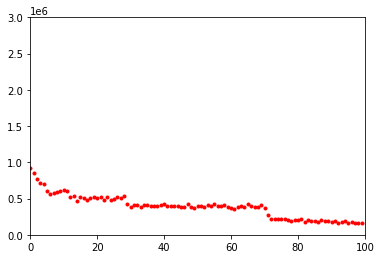

(104720261, 120091400)

In [24]:
model = Word2Vec(window = 5, min_count = 10) #increase min_count
model.build_vocab(for_embed)  # prepare the model vocabulary
model.train(for_embed, total_examples=model.corpus_count, epochs=100, compute_loss = True, callbacks=[callback()])

In [ ]:
#word2vec_update 100 epochs with sentences (only token embeddings) min_count = 10

#word2vec_100e 100 epochs with with_sw (with stop words)
#word2vec_tokenup 100 epochs with sentences (only token embeddings) min_count = 5

In [25]:
#save word2vec embeddings for model training
word_vectors = model.wv
word_vectors.save("/content/drive/My Drive/word2vec_update")

In [58]:
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings

glove_embedding = WordEmbeddings("/content/drive/My Drive/word2vec_update")
document_glove_embeddings = DocumentPoolEmbeddings([glove_embedding])

In [59]:
len(docs_clean)

11963

In [60]:
#this model recommends training with 50 topics or above
topic_model = BERTopic(nr_topics = 10, calculate_probabilities = True, embedding_model = document_glove_embeddings)

In [61]:
topics, prob = topic_model.fit_transform(docs_clean)

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:126: UserWarning:

A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 70 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.



In [63]:
#remove stop words and change n-gram range
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 1), stop_words="english")

topic_model.update_topics(docs_clean, topics, vectorizer_model=cv)

In [64]:
topic_model.get_topic_freq().head(10)

,Topic,Count
0,5,11421
1,4,436
2,3,42
3,1,27
4,2,16
5,0,12
6,-1,9


In [65]:
topic_model.get_topic_info()

,Topic,Count,Name
0,5,11421,5_covid_just_year_time
1,4,436,4_shark_kill_ocean_human
2,3,42,3_musk_elon_swisher_kara
3,1,27,1_impeach_trump_herd_health
4,2,16,2_url_attach_typeful_unfurltruehttpswwwtheguar...
5,0,12,0_life_sort_cost_ago
6,-1,9,-1_alon_httpswwwnvicorgvaccinesanddiseasesinfl...


In [21]:
topic_model.save('/content/drive/My Drive/word2vec_90token')

In [22]:
np.save('/content/drive/My Drive/topic_90token', topics)
np.save('/content/drive/My Drive/prob_90token', prob)

In [ ]:
# ALL FITTED TO DOCS_CLEAN
#word2vec_tokenmodel50topic without stopwords and n-gram 1,1
   #topic_w2v_1ng
   #prob_w2v_1ng

#word2vec_token_ngram2 without stopwards and n-gram 1,3 also 50 topics
   #prob_w2v_2ng
   #topic_w2v_2ng

#word2vec_10 is without stopwards and n-gram 1, 2 with 10 topics
   #prob_10
   #topic_10

# FITTED TO NEW_TOKENS
# word2vec_token_15 n-gram 1,2 with 15 topics
  #topic_w2v_15
  #prob_w2v_15

# word2vec_token_10 n-gram 1,2 with 10 topics
  #topic_w2v_10
  #prob_w2v_10

#SENTENCES TEXT
#word2vec_90dcold fitted to docs_clean_old with min_count = 10
  #topic_90dcold
  #prob_90dcold

#word2vec_90token fitted on my_tokens with min_count = 10 
  #topic_90token 
  #prob_90token

# **W2V ANALYSIS**

In [ ]:
topics_over_tim = topic_model.topics_over_time(docs_clean_old, topics, clean_times, evolution_tuning = True,
                         global_tuning = False)

In [ ]:
topic_model.visualize_topics_over_time(topics_over_tim, top_n=5) #fitted to docs_clean

In [ ]:
best = BERTopic.load('/content/drive/My Drive/word2vec_10')

In [ ]:
top = np.load('/content/drive/My Drive/topic_10.npy')
pro = np.load('/content/drive/My Drive/prob_10.npy')

In [ ]:
best.get_topic_info()

,Topic,Count,Name
0,-1,18790,-1_vaccine_people_covid_think
1,198,1756,198_vaccine_dose_pfizer_covid
2,236,1188,236_people_know_covid_like
3,142,784,142_covid_people_work_time
4,260,725,260_trump_biden_president_administration
5,328,632,328_arm_sore_sore arm_shot
6,271,519,271_president_trump_president trump_herd immunity
7,220,515,220_death_case_000_number
8,276,395,276_people_vaccinate_vaccinated_people old
9,121,377,121_vaccine_covid_people_covid vaccine


In [ ]:
topics_over_time = best.topics_over_time(docs_clean, top, clean_times, evolution_tuning = True,
                         global_tuning = False)

In [ ]:
best.visualize_topics_over_time(topics_over_time, top_n=5) #fitted to docs_clean

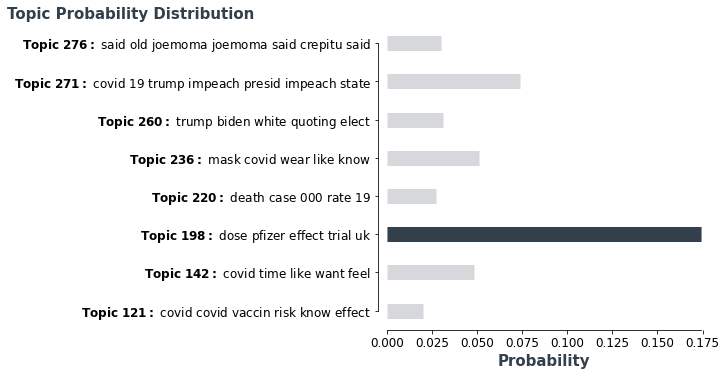

In [ ]:
best.visualize_distribution(pro[3])

In [ ]:
docs_clean[3]

"quot from: nelson4lov on septemb 25 2020 pm whi are bitcoin and altcoin market drop lately? here are a coupl of reasons: 1. second wave of covid-19 fears: there' fud current go round that we might possibl see anoth market sell-off due to the increas number of covid-19 case and death throughout august and september. if it turn out to be true we'll see a sell off but not as bad as the one in that happen in march. 2. covid-19 vaccines: it' no longer news that financi market (includ the crypto market) would take the neg turn if a vaccin get approv as a cure for the virus. the problem with these kind of rumor is that they usual turn our to be safe fulfil prophecies. as they say \x96buy the rumor sell the news. 3. a regular market correction: crypto market peak in august with bitcoin increas more than 3x sinc the atl in march. other altcoin have also seen signific gains. like went from as low as $2 to $19. so the market wa long overdu for a correction. these point are realli point to the re

In [ ]:
best.find_topics('covid')

([-1, 121, 142, 236, 220],
 [0.8566866950395018,
  0.7826718560311308,
  0.6796910112700134,
  0.5570599476131947,
  0.3903457854109401])

In [ ]:
best2 = BERTopic.load('/content/drive/My Drive/word2vec_token_10')

In [ ]:
top2 = np.load('/content/drive/My Drive/topic_w2v_10.npy')
pro2 = np.load('/content/drive/My Drive/prob_w2v_10.npy')

In [ ]:
topics_over_time = best2.topics_over_time(new_tokens, top2, clean_times, evolution_tuning = True,
                         global_tuning = False)

In [ ]:
best2.visualize_topics_over_time(topics_over_time, top_n=5) #fitted to tokens

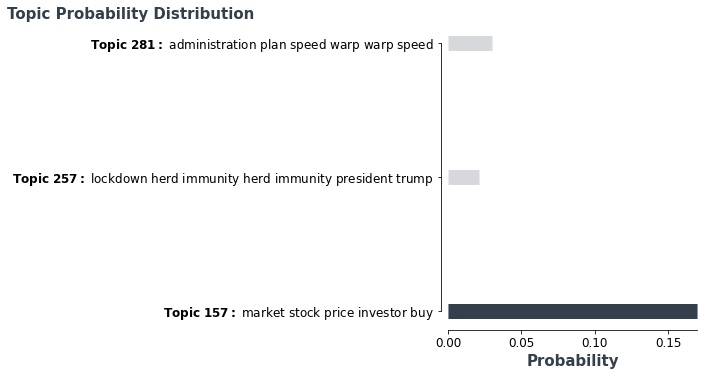

In [ ]:
best2.visualize_distribution(pro2[3])

In [ ]:
best2.find_topics('covid')

([-1, 184, 173, 81, 257],
 [0.7505358366044297,
  0.6673080931468828,
  0.3943508153389468,
  0.21426454718058077,
  0.16730388968703938])

# **FastText Embeddings** 



In [26]:
from gensim.models import FastText 

modeling = FastText(size=100, window=5, min_count=10) 
modeling.build_vocab(sentences=for_embed)
modeling.train(for_embed, total_examples=len(for_embed), epochs=100, sg = 1, compute_loss=True)  # set sg = 1

In [27]:
word_vectorss = modeling.wv
word_vectorss.save("/content/drive/My Drive/fasttext90")

In [ ]:
#fasttext trained with 100e on tokens
#fasttext_sw trained with 100e with stop words in sentences
#fasttext90 fitted on new tokens
#fasttext90dco fitted on new text

In [28]:
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings

glove_embedding = WordEmbeddings("/content/drive/My Drive/fasttext90")
document_glove_embeddings = DocumentPoolEmbeddings([glove_embedding])

In [29]:
topic_modeling = BERTopic(nr_topics = 10, calculate_probabilities = True, embedding_model=document_glove_embeddings)

In [70]:
len(docs_clean_old)

26040

In [36]:
topics, probabilities = topic_modeling.fit_transform(docs_clean_old)

In [38]:
#remove stop words and change n-gram range
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 1), stop_words="english")
topic_modeling.update_topics(docs_clean_old, topics, vectorizer_model=cv)

In [39]:
topic_modeling.get_topic_freq().head(10)

,Topic,Count
0,-1,23484
1,239,388
2,361,333
3,214,277
4,160,268
5,268,268
6,319,266
7,316,243
8,368,194
9,142,161


In [40]:
topic_modeling.get_topic(239)

[('sharks', 0.40026938914220267),
 ('animals', 0.0839521916866849),
 ('shark', 0.08175514559202553),
 ('oceans', 0.057163399638648096),
 ('ocean', 0.054968756250478326),
 ('ecosystem', 0.04758262102365123),
 ('humans', 0.0401066722831783),
 ('creatures', 0.03953345570102064),
 ('human', 0.023940414754298162),
 ('animal', 0.022866415522175877)]

In [50]:
np.save('/content/drive/My Drive/array_topics_90dco', topics)
np.save('/content/drive/My Drive/array_probabilities_90dco', probabilities)

In [51]:
topic_modeling.save('/content/drive/My Drive/fasttext90_dc')

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [ ]:
#FITTED WITH NEW_TOKENS

#fasttext_50 model with topic reduction to 50
    #array_topics_ftno fitted with new_tokens, 50 topics, cv, n-gram 1,1
    #array_probabilities_ftno fitted with new_tokens, 50 topics, cv, n-gram 1, 1

#fasttext_15_ng2 model with n-gram changed to 1,2 and topic size is 15
    #array_topics_ft15 fitted with new_tokens
    #array_probabilities_ft15

#fasttext_10_ng2 model with n-gram changed to 1,2 and topic size is 10
    #array_topics_ft10 fitted with new_tokens
    #array_probabilities_ft10

#SENTENCES TEXT FITTED
#fasttext90tok model with n-gram changed to 1,1 and topic size is 10
    #array_topics_90tok fitted with new_tokens
    #array_probabilities_90tok

#fasttext90_dc model with n-gram changed to 1,1 and topic size is 10 on dc old
    #array_topics_90dco fitted with docs_clean_old
    #array_probabilities_90dco

# **FASTTEXT ANALYSIS**

In [43]:
bestf = BERTopic.load('/content/drive/My Drive/fasttext_10_ng2')
topf = np.load('/content/drive/My Drive/array_topics_ft10.npy')
prof = np.load('/content/drive/My Drive/array_probabilities_ft10.npy')

In [ ]:
bestf.get_topic_freq().head(6)

In [ ]:
topics_over_time = bestf.topics_over_time(new_tokens, topf, clean_times, evolution_tuning = True,
                         global_tuning = False)

In [ ]:
bestf.visualize_topics_over_time(topics_over_time, topics = [70,176,290,368,378])

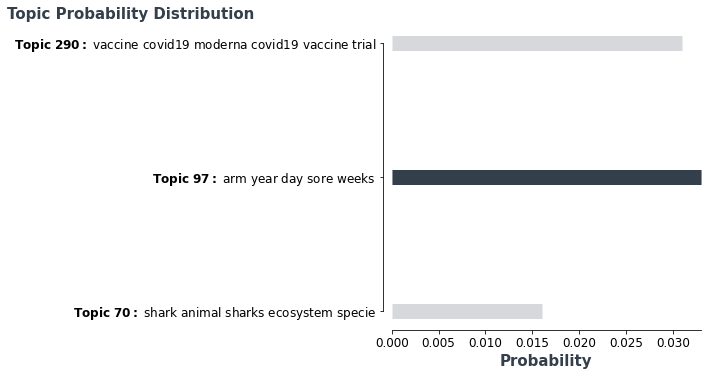

In [ ]:
bestf.visualize_distribution(prof[3])

In [ ]:
bestf.find_topics("covid")

([-1, 176, 290, 264, 156],
 [0.7619295578389759,
  0.5224152148982532,
  0.3816241651274538,
  0.3634569509126971,
  0.26850584838515357])

In [ ]:
bestf2 = BERTopic.load('/content/drive/My Drive/fasttext_15_ng2')
topf2 = np.load('/content/drive/My Drive/array_topics_ft15.npy')
prof2 = np.load('/content/drive/My Drive/array_probabilities_ft15.npy')

In [ ]:
topics_over_time = bestf2.topics_over_time(new_tokens, topf2, clean_times, evolution_tuning = True,
                         global_tuning = False)

In [ ]:
bestf2.visualize_topics_over_time(topics_over_time, topics=[63,102,105,264,331])

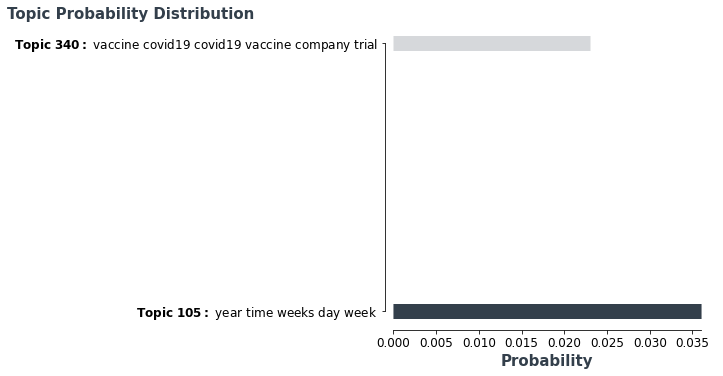

In [ ]:
bestf2.visualize_distribution(prof2[3])

In [ ]:
bestf2.find_topics("covid")

([-1, 102, 312, 264, 340],
 [0.7601078047263611,
  0.46351903996075755,
  0.38604884589988525,
  0.37059165961729584,
  0.3632601630284634])

# **Sentence Transformers**

In [36]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from torch import nn

# Use BERT for mapping tokens to embeddings
word_model = SentenceTransformer('bert-base-uncased')
embeddings = word_model.encode(my_tokens, show_progress_bar=True)

In [37]:
topic_model_st = BERTopic(nr_topics = 10, calculate_probabilities=True, embedding_model = [embeddings])

In [57]:
len(my_tokens)

11963

In [41]:
topics, probabilities = topic_model_st.fit_transform(my_tokens)

In [42]:
#remove stop words and change n-gram range
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 1), stop_words="english")

topic_model_st.update_topics(my_tokens, topics, vectorizer_model=cv)

In [ ]:
topic_model_st.get_topic_freq().head(10)

In [48]:
topic_model_st.save('/content/drive/My Drive/sentencetrans_90tok')

In [50]:
np.save('/content/drive/My Drive/topic_90stok', topics)
np.save('/content/drive/My Drive/prob_90stok', probabilities)

In [ ]:
#torch.cuda.is_available()

In [ ]:
st = BERTopic.load('/content/drive/My Drive/sentencetrans_90tok')
topst = np.load('/content/drive/My Drive/topic_90stok.npy')
prost = np.load('/content/drive/My Drive/prob_90stok.npy')

In [56]:
st.visualize_topics()

In [58]:
topics_over_time = st.topics_over_time(my_tokens, topst, clean_times, evolution_tuning = True,
                         global_tuning = False)
st.visualize_topics_over_time(topics_over_time, top_n=5) #fitted to tokens

In [40]:
st2 = BERTopic.load('/content/drive/My Drive/sentencetrans_90dcold')
topst2 = np.load('/content/drive/My Drive/topic_90stold.npy')
prost2 = np.load('/content/drive/My Drive/prob_90stold.npy')

In [25]:
st2.visualize_topics()

In [73]:
topics_over_time = st2.topics_over_time(docs_clean_old, topst2, clean_times_o, evolution_tuning = True,
                         global_tuning = False)
st2.visualize_topics_over_time(topics_over_time, top_n=5) #fitted to docs_clean

In [ ]:
#sentencetrans_90dcold - tokens 90k, with docs clean old 10 topics bert uncased
#prob_90stold
#topic_90stold

#sentencetrans_90dc - tokens 90k, with docs clean new 10 topics bert uncased
#prob_90st
#topic_90st

#sentencetrans_90tok - tokens 90k, with tokens new 10 topics bert uncased
#prob_90stok
#topic_90stok

## **Analysis of Models with New Data (90K+ sentences)**

In [9]:
best3 = BERTopic.load('/content/drive/My Drive/word2vec_90dcold')
top3 = np.load('/content/drive/My Drive/topic_90dcold.npy')
pro3 = np.load('/content/drive/My Drive/prob_90dcold.npy')

In [24]:
best3.visualize_topics()

In [32]:
topics_over_time = best3.topics_over_time(docs_clean_old, top3, clean_times_o, evolution_tuning = True,
                         global_tuning = False)
best3.visualize_topics_over_time(topics_over_time, top_n=5) #fitted to docs_clean

In [10]:
best4 = BERTopic.load('/content/drive/My Drive/word2vec_90token')
top4 = np.load('/content/drive/My Drive/topic_90token.npy')
pro4 = np.load('/content/drive/My Drive/prob_90token.npy')

In [24]:
best4.visualize_topics()

In [33]:
topics_over_time = best4.topics_over_time(my_tokens, top4, clean_times, evolution_tuning = True,
                         global_tuning = False)
best4.visualize_topics_over_time(topics_over_time, top_n=5) #fitted to tokens

In [11]:
ft3 = BERTopic.load('/content/drive/My Drive/fasttext90tok')
topft3 = np.load('/content/drive/My Drive/array_topics_90tok.npy')
proft3 = np.load('/content/drive/My Drive/array_probabilities_90tok.npy')

In [59]:
ft3.visualize_topics()

In [34]:
topics_over_time = ft3.topics_over_time(my_tokens, topft3, clean_times, evolution_tuning = True,
                         global_tuning = False)
ft3.visualize_topics_over_time(topics_over_time, top_n=5) #fitted to tokens

In [12]:
ft4 = BERTopic.load('/content/drive/My Drive/fasttext90_dc')
topft4 = np.load('/content/drive/My Drive/array_topics_90dco.npy')
proft4 = np.load('/content/drive/My Drive/array_probabilities_90dco.npy')

In [60]:
ft4.visualize_topics()

In [28]:
topics_over_time = ft4.topics_over_time(docs_clean_old, topft4, clean_times_o, evolution_tuning = True,
                         global_tuning = False)
ft4.visualize_topics_over_time(topics_over_time, top_n=5) #fitted to docs_clean

In [42]:
dictionary = list(best4.get_topics().values())
diction = dictionary[1:] #remove outlier topic
p = 0
final_t = []
for i in range(len(diction)):
  final_t.append([])

for key in diction:
    for i in key:
        final_t[p].append(i[0])
    p+=1

In [44]:
best4.get_topics()

{-1: [('vaccine', 0.03630294016264705),
  ('covid', 0.027010199334535488),
  ('people', 0.024393216616502584),
  ('think', 0.01519138116530234),
  ('know', 0.015110684346588344),
  ('virus', 0.013984451078719725),
  ('time', 0.013637903429301722),
  ('vaccinate', 0.010305308474427562),
  ('vaccination', 0.01018134955815634),
  ('flu', 0.00940157960447115)],
 2: [('shark', 0.22339934452455007),
  ('animal', 0.12147153858858117),
  ('ocean', 0.07087272587902406),
  ('sharks', 0.06779837083688521),
  ('ecosystem', 0.04958696242798688),
  ('squalene', 0.04826311884182044),
  ('sustainable', 0.04044559674017974),
  ('specie', 0.03497973789474179),
  ('planet', 0.03182137962943078),
  ('creature', 0.02630827542687283)],
 20: [('death', 0.0884018066876195),
  ('covid', 0.04169774673669099),
  ('flu', 0.03490299862045715),
  ('number', 0.032709642712512026),
  ('rate', 0.031658103001741406),
  ('die', 0.029733451845756154),
  ('people', 0.028491523973228974),
  ('case', 0.027993556396246365),


In [34]:
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
dictionary = corpora.Dictionary(for_embed)
corpus = [dictionary.doc2bow(text) for text in for_embed]

In [ ]:
final_t

In [ ]:
cm = CoherenceModel(topics=final_t, texts = for_embed, dictionary = dictionary, coherence='c_v')
coherence = cm.get_coherence()
coherence


### ***Coherence Scores***
1.   ft3 - fasttext embeddings (using tokens from 90k+ sentences) fitted to text
           0.6638420759086465
2.   best4 - word2vec embeddings fitted to tokens 
           0.6379036824750437
3.   best3 - word2vec embeddings fitted to text
           0.5766920212674094
4.   st - bert uncased embeddings fitted to tokens
           0.4724439138356634
5.   st2 - bert uncased embeddings fitted to text
           0.41351789128197
6.   ft4 - fasttext embeddings fitted to tokens
           0.40644196566567514 


# **Extra BERTopic**

In [ ]:
u_mass = []
flags = []
for n, topic in enumerate(final_t):
    try:
        cm = CoherenceModel(topics=topic, texts = docs_coh, dictionary=dictionary, coherence='u_mass')
        u_mass.append(cm.get_coherence())
    except KeyError:
        flags.append(n)

In [1]:
def find_docs(topic_id):
    x = []
    for idx, item in enumerate(top2):
        if top2[idx]==topic_id:
            x.append(idx)
    return x

In [ ]:
found_docs = find_docs(3)

In [ ]:
for i in range(5):   
    print(f"Document: {found_docs[i]}")
    print("-----------")
    print(new_tokens[found_docs[i]]) 
    print("-----------")
    print()


In [ ]:
best2.visualize_distribution(pro2[found_docs[1]])